## Imports

In [1]:
# Generales
import torch
import os
import json
import sys
import pandapower as pp
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from omegaconf import OmegaConf


# Julia
import julia
julia.install()
from julia.api import Julia
jl = Julia(compiled_modules=False)



sys.path.append(os.path.abspath('../entrenamiento'))
from src.arquitecturas import GNNUnsupervised, FCNNUnsupervised
from src.Data_loader import load_net, load_data
from src.train_eval import run_epoch, evaluate
from src.utils import get_Ybus, get_Yline, init_lamdas
from src.Loss import my_loss, get_max_min_values
from src.metric import feas_and_volt_metric
from find_best_run import find_best_run


import warnings
warnings.filterwarnings('ignore')


red = "uru"
net = "fcnn"
dt =  find_best_run(f"./runs_ploss_final/{net}/uru/")[0][0]
# dt = '09-15_16:57:04'
print(dt)
cfg = OmegaConf.load(f"./runs_ploss_final/{net}/uru/" + dt + "/config.yaml")
weights_dir = f"./runs_ploss_final/{net}/uru/" + dt +  "/weights/best_model.pt"

# Set device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Set network
edge_index, edge_weights, net = load_net(cfg.data.red,cfg.data.red_path,device)


net.bus["pm_param/setpoint_v"] = 1.0

pp.runpp(net)
Y_bus = get_Ybus(net,device)
Y_line = get_Yline(net,device)
max_ika = torch.Tensor(net.line["max_i_ka"]).to(device)

# Set model
dual_variables = init_lamdas(net,cfg.training.dual_coefs,device)
min_vector, max_vector = get_max_min_values(net,device)
num_layers = len(cfg.model.layers) - 1
num_nodes = len(net.bus)


if cfg.model.arq == "GNN":
    model = GNNUnsupervised(cfg.model.layers, edge_index, Y_bus, num_layers, cfg.model.K, min_vector, max_vector, num_nodes,cfg.model.dropout,batch_norm=cfg.training.batch_norm).to(device)
elif cfg.model.arq == "FCNN":
    model = FCNNUnsupervised(cfg.model.layers, edge_index, Y_bus, num_layers, cfg.model.K, min_vector, max_vector, num_nodes,cfg.model.dropout,batch_norm=cfg.training.batch_norm).to(device)
# Load data
train_loader, val_loader, test_loader, norm_X = load_data(cfg.data.data_path, cfg.training.batch_size, cfg.data.normalize_X, cfg.data.red, device)
train_loader_unorm, val_loader_unorm, test_loader_unorm, _ = load_data(cfg.data.data_path, cfg.training.batch_size, False, cfg.data.red, device)

# Cargo los pesos al modelo guardados en weights_dir +weights.pt
model.load_state_dict(torch.load(weights_dir))
model.eval()

[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.5 LTS
  uname: Linux 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4598 MHz     126018 s         29 s      15554 s   44340490 s          0 s
  Memory: 62.63290023803711 GB (41099.53125 MB free)
  Uptime: 278052.43 sec
  Load Avg:  2.62  1.33  0.74
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/nacho
  PATH = /home/nacho/miniconda3/envs/proy/bin:/home/nacho/.vscode-server/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/home/nacho/.local/bin:/home/nacho/miniconda3/envs/proy/bin:/home/nacho/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr

[ Info: Julia executable: /home/nacho/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /home/nacho/miniconda3/envs/proy/bin/python
│ Julia executable:
│     /home/nacho/julia-1.8.1/bin/julia
└ @ Main ~/miniconda3/envs/proy/lib/python3.12/site-packages/julia/install.jl:90
[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.5 LTS
  uname: Linux 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4100 MHz     126228 s         29 s      15596 s   44342518 s          0 s
  Memory: 62.63290023803711 GB (42117.27734375 MB free)
  Uptime: 278066.69 sec
  Load Avg:  2.33  1.33  0.75
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/nacho
  PATH = /home/nacho/miniconda3/envs/proy/bin:/home/nacho/.vscode-server/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/home/nacho/.local/bin:/home/nacho/miniconda3/envs/proy/bin:/home/nacho/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/

[ Info: Julia executable: /home/nacho/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /home/nacho/miniconda3/envs/proy/bin/python
│ Julia executable:
│     /home/nacho/julia-1.8.1/bin/julia
└ @ Main ~/miniconda3/envs/proy/lib/python3.12/site-packages/julia/install.jl:90


10-03_10:35:51


UserWarning: File /home/iboero/unsup_uru/data/red_uru_final.p does not exist!!

In [16]:
bus_map = {net.bus.index[i]: i for i in range(len(net.bus))}


# That also works for a list of buses
def bus_pos(buses):
    try:
        return [bus_map[bus] for bus in buses]
    except:
        return bus_map[buses]

In [17]:
data_path = cfg.data.data_path

y_tensor_val_vmpu = torch.Tensor(np.load(f'{data_path}/val/vm_pu_opt.npy')).to(device)
y_tensor_val_qsh = torch.Tensor(np.load(f'{data_path}/val/q_switch_shunt_opt.npy')).to(device)
# y_tensor_val = torch.concat([y_tensor_val_vmpu,y_tensor_val_qsh],dim=-1)

data_val_v = TensorDataset( y_tensor_val_vmpu)
val_loader_Y_v = DataLoader(data_val_v, batch_size=cfg.training.batch_size)#,drop_last=True)

data_val_sh = TensorDataset( y_tensor_val_qsh)
val_loader_Y_sh = DataLoader(data_val_sh, batch_size=cfg.training.batch_size)#,drop_last=True)

combined_dataloader = zip(val_loader, val_loader_Y_v,val_loader_Y_sh )


idx_gens = net.gen.bus.values.astype(int)
idx_load = net.load.bus.values.astype(int)
idx_shunts = net.sgen.bus.loc[net.sgen.controllable==True].values.astype(int)
idx_sgen = net.sgen.bus.loc[net.sgen.controllable==False].values.astype(int)

y_pred_vmpu = []
y_pred_sh = []
x_tot = []
y_tot_vmpu = []
y_tot_sh = []
y_pred = []
for input,y_vmpu,y_sh in combined_dataloader:
    output = model(input[0]).detach().cpu().numpy()
    y_pred.append(output)
    y_pred_vmpu.append(output[:,:,3])
    y_pred_sh.append(output[:,:,2])
    # x_tot.append(input.detach().cpu().numpy())
    y_tot_vmpu.append(y_vmpu[0].detach().cpu().numpy())
    y_tot_sh.append(y_sh[0].detach().cpu().numpy())

for input in val_loader_unorm:
    x_tot.append(input[0].detach().cpu().numpy())


# Concatenate in dim 0
y_pred_vmpu = np.concatenate(y_pred_vmpu, axis=0)
y_pred_vmpu = y_pred_vmpu[:,:,None]
y_pred_sh = np.concatenate(y_pred_sh, axis=0)
y_pred_sh = y_pred_sh[:,:,None]
x_tot = np.concatenate(x_tot, axis=0)
y_tot_vmpu = np.concatenate(y_tot_vmpu, axis=0)
y_tot_vmpu = y_tot_vmpu[:,:,None]
y_tot_sh = np.concatenate(y_tot_sh, axis=0)
y_tot_sh = y_tot_sh[:,:,None]
y_pred = np.concatenate(y_pred, axis=0)
 

### Analisis VMPU

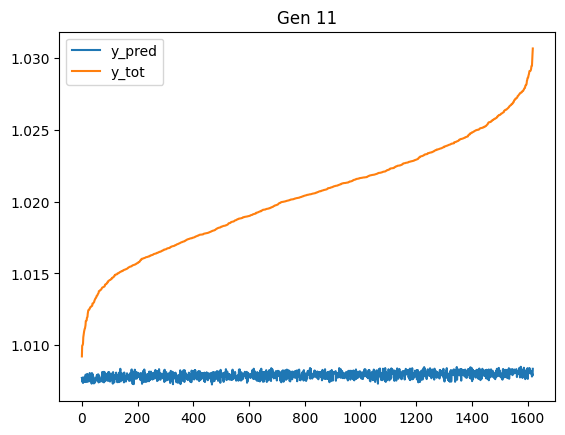

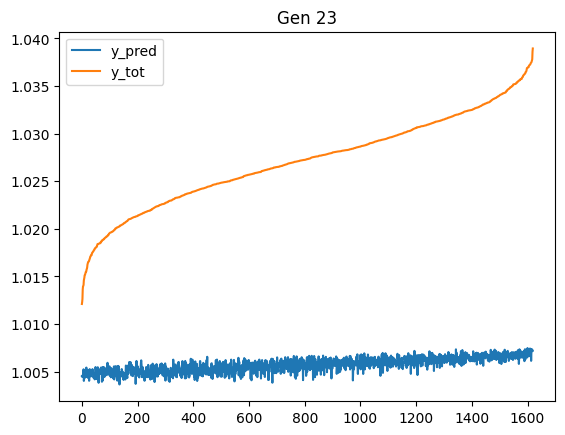

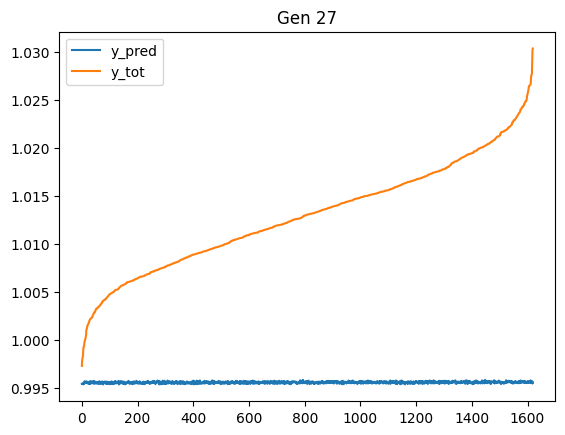

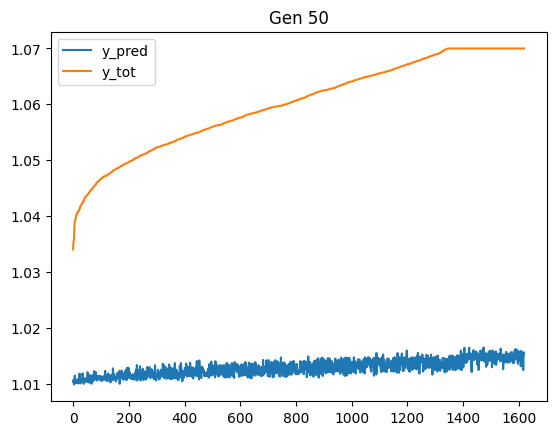

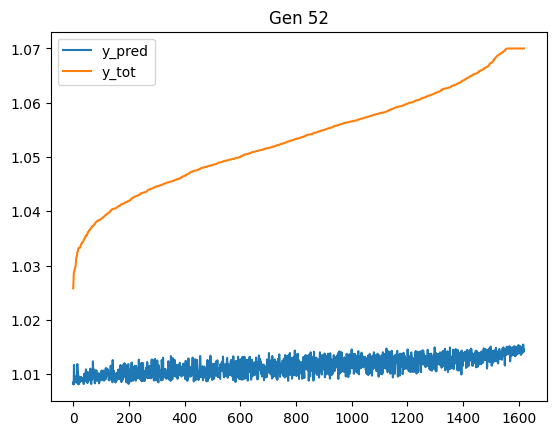

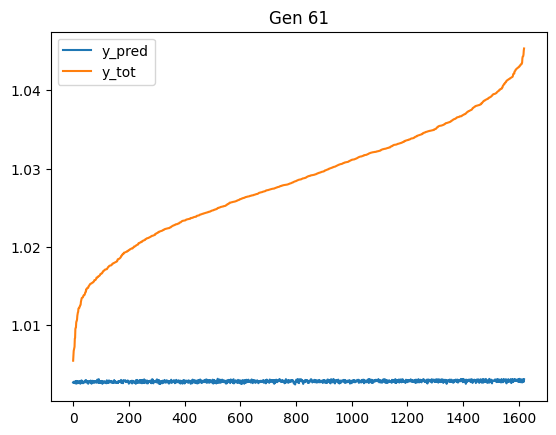

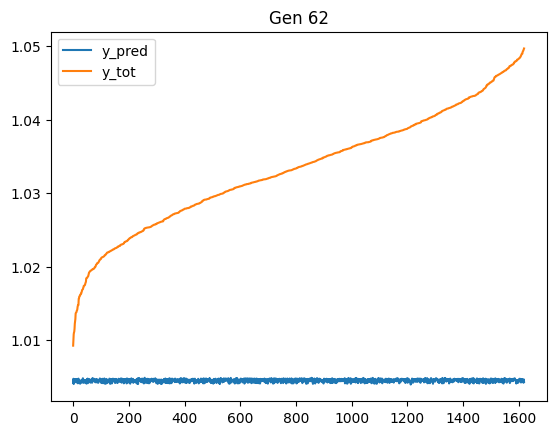

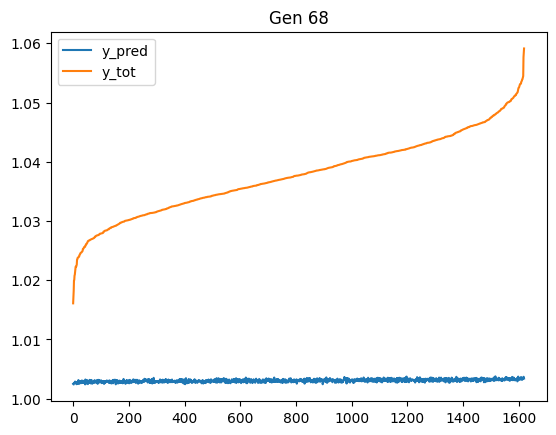

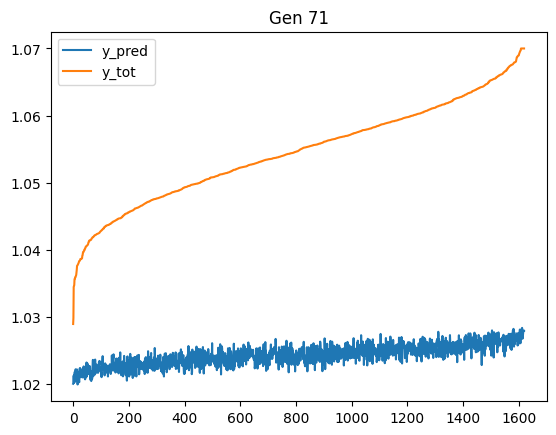

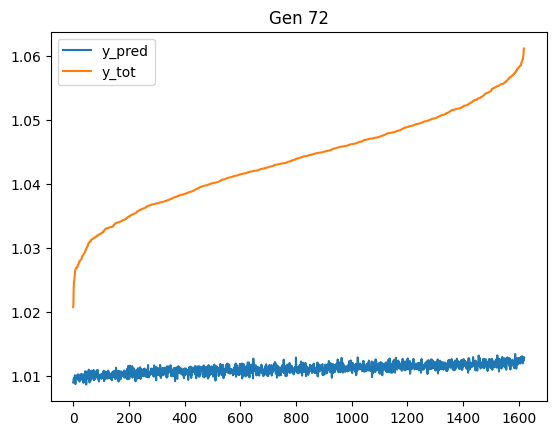

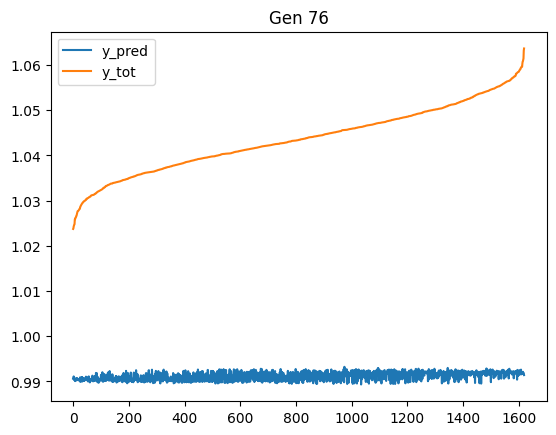

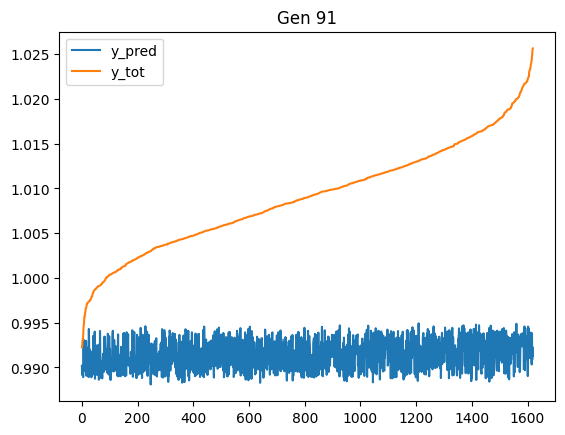

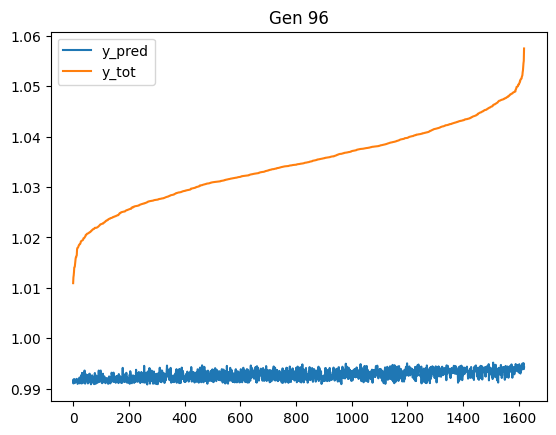

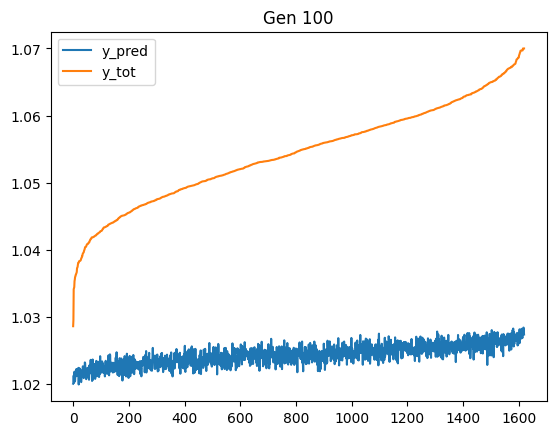

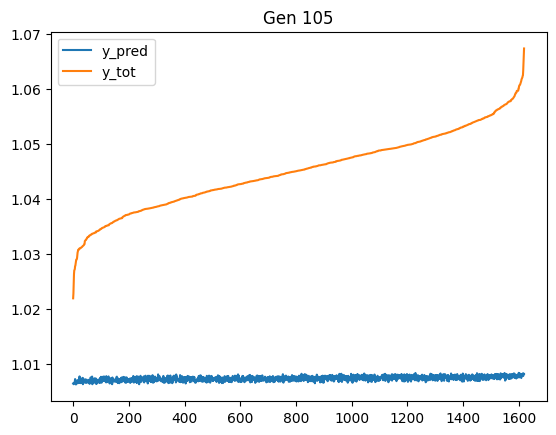

In [19]:
import matplotlib.pyplot as plt


# Plot an histagram per gen of y_pred and y_tot
for i in bus_pos(idx_gens):
    plt.figure()
    # order y_tot[:,i] from smallest to largest and y_pred[:,i] witj same order
    idx = np.argsort(y_tot_vmpu[:,i].squeeze())
    y_tot_i = y_tot_vmpu[idx,i].squeeze()
    y_pred_i = y_pred_vmpu[idx,i].squeeze()
    
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    plt.title(f"Gen {i}")
    plt.legend()
    plt.show()

### ANALISIS Q SHUNT

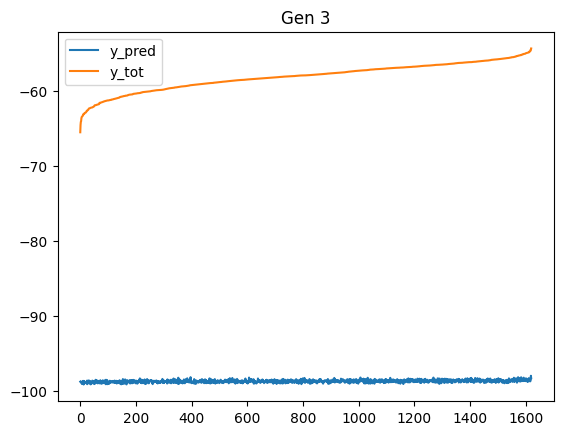

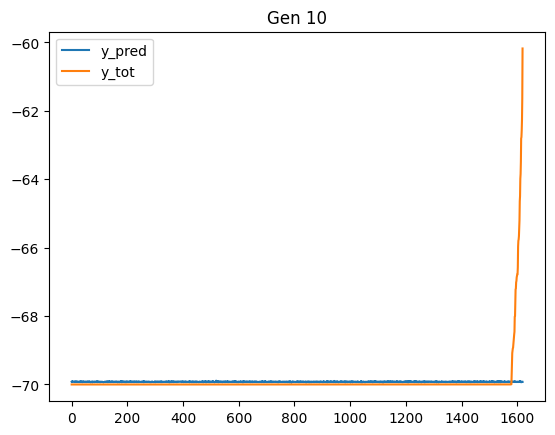

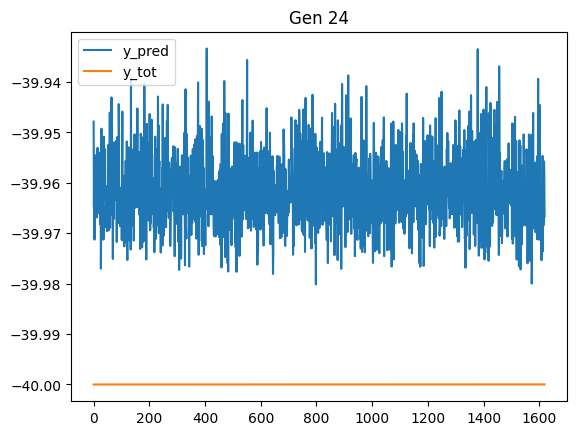

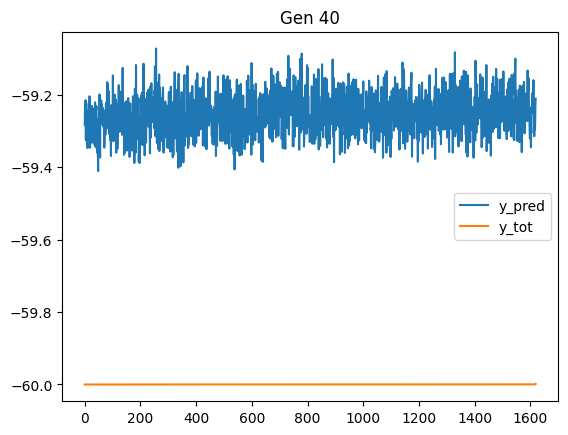

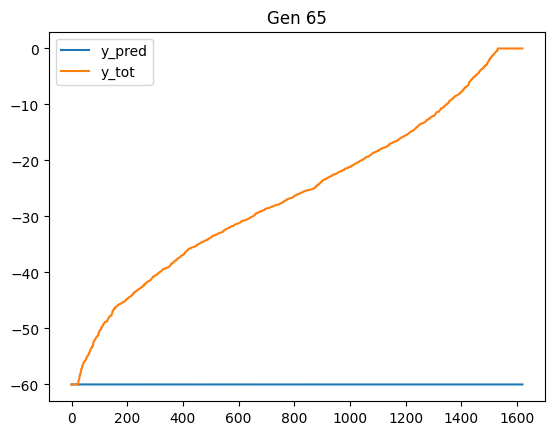

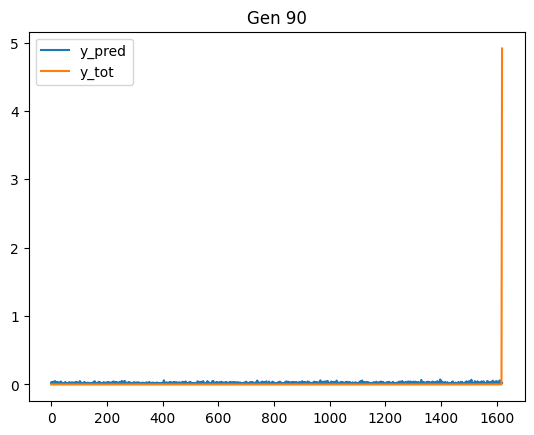

In [20]:
import matplotlib.pyplot as plt


# Plot an histagram per gen of y_pred and y_tot
for i in bus_pos(idx_shunts):
    plt.figure()
    # order y_tot[:,i] from smallest to largest and y_pred[:,i] witj same order
    idx = np.argsort(y_tot_sh[:,i].squeeze())
    y_tot_i = y_tot_sh[idx,i].squeeze()
    y_pred_i = y_pred_sh[idx,i].squeeze() * 100
    
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    plt.title(f"Gen {i}")
    plt.legend()
    plt.show()

## Asegurarse datos correctos

In [21]:

run = False

if run:
    idx = 1

    net.load.loc[:,'p_mw'] = x_tot[idx,bus_pos(idx_load),0] * 100
    net.load.loc[:,'q_mvar'] = x_tot[idx,bus_pos(idx_load),1] * 100
    net.gen.loc[:,'p_mw'] =  x_tot[idx,bus_pos(idx_gens),2] * 100
    net.sgen.p_mw.loc[net.sgen.controllable==False] = x_tot[idx,bus_pos(idx_sgen),3] * 100

    net.gen.loc[:,"max_p_mw"] = net.gen['p_mw']
    net.gen.loc[:,"min_p_mw"] = net.gen['p_mw']

    net.line["pm_param/target_branch"] = True

    pp.runpm_ploss(net)


    assert np.allclose(net.res_gen.vm_pu.values, y_tot_vmpu[idx, bus_pos(idx_gens)].squeeze(), atol=1e-5)
    assert np.allclose(net.res_sgen[net.sgen.controllable==True].q_mvar.values, y_tot_sh[idx, bus_pos(idx_shunts)].squeeze(), atol=1e-5)


    # net.res_bus
    Y_bus_cpu = Y_bus.cpu().numpy()
    v_m, delta = net.res_bus.vm_pu.values, net.res_bus.va_degree.values
    delta = np.radians(delta)
    v = v_m * (np.cos(delta) + np.sin(delta)*1j)
    s = -(net.res_bus.p_mw.values + 1j*net.res_bus.q_mvar.values)/100

    np.dot(np.diag(v), np.conj(np.dot(Y_bus_cpu, v))) - s


In [22]:
# net.gen.vm_pu = net.res_gen.vm_pu.values
# net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = net.res_sgen[net.sgen.controllable==True].q_mvar.values
# pp.runpp(net)
# # net.res_bus

# v_m, delta = net.res_bus.vm_pu.values, net.res_bus.va_degree.values
# delta = np.radians(delta)
# v = v_m * (np.cos(delta) + np.sin(delta)*1j)
# s = -(net.res_bus.p_mw.values + 1j*net.res_bus.q_mvar.values)/100

# np.dot(np.diag(v), np.conj(np.dot(Y_bus_cpu, v))) - s

## Evaluar

In [23]:
# # def get_stats(net,tol=1e-4):
# #     # METRICA
# #     Y_line_ij = np.asarray(net._ppc["internal"]["Yf"].todense())
# #     Y_line_ji = np.asarray(net._ppc["internal"]["Yt"].todense())
# #     V_mag = net.res_bus.vm_pu
# #     delta = net.res_bus.va_degree
# #     V = V_mag * np.exp(1j * delta * 2*np.pi/360)
# #     V_lines_to = [V[x] for x in net.line.to_bus] + [V[x] for x in net.trafo.lv_bus]
# #     V_lines_from = [V[x] for x in net.line.from_bus] + [V[x] for x in net.trafo.hv_bus]
# #     ploss = (V_lines_from * np.conj(np.matmul(Y_line_ij,V)) + V_lines_to * np.conj(np.matmul(Y_line_ji,V))).real * net.sn_mva
# #     ploss_cost = ploss.sum()
    
# #     # v_cost = (np.abs(net.res_bus.vm_pu.values - 1)**2).sum()
# #     unfeas_line = (net.res_line.loading_percent.values > net.line.max_loading_percent.values + tol).sum()
# #     unfeas_trafo = 0
# #     if len(net.trafo) > 0:
# #         unfeas_trafo = (net.res_trafo.loading_percent.values > net.trafo.max_loading_percent.values + tol).sum()
# #     else:
# #         unfeas_trafo = 0
# #     unfeas_volt = (net.res_bus.vm_pu.values < net.bus.min_vm_pu.values - tol).sum() + (net.res_bus.vm_pu.values > net.bus.max_vm_pu.values + tol).sum()
# #     unfeas_q_ext_grid = (net.res_ext_grid.q_mvar.values < net.ext_grid.min_q_mvar.values - tol).sum() + (net.res_ext_grid.q_mvar.values > net.ext_grid.max_q_mvar.values + tol).sum()

# #     if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0 or unfeas_q_ext_grid > 0:
# #         unfeas = True
# #     else:
# #         unfeas = False
# #     return ploss_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt, unfeas_q_ext_grid]

# def get_stats(net,tol=1e-3):
#     # METRICA
#     Y_line_ij = np.asarray(net._ppc["internal"]["Yf"].todense())
#     Y_line_ji = np.asarray(net._ppc["internal"]["Yt"].todense())
#     V_mag = net.res_bus.vm_pu
#     delta = net.res_bus.va_degree
#     V = V_mag * np.exp(1j * delta * 2*np.pi/360)
#     V_lines_to = [V[x] for x in net.line.to_bus] + [V[x] for x in net.trafo.lv_bus]
#     V_lines_from = [V[x] for x in net.line.from_bus] + [V[x] for x in net.trafo.hv_bus]
#     ploss = (V_lines_from * np.conj(np.matmul(Y_line_ij,V)) + V_lines_to * np.conj(np.matmul(Y_line_ji,V))).real * net.sn_mva
#     ploss_cost = ploss.sum()
    
#     unfeas_line = (net.res_line.loading_percent.values > net.line.max_loading_percent.values + tol).sum()
#     unfeas_trafo = 0
#     if len(net.trafo) > 0:
#         unfeas_trafo = (net.res_trafo.loading_percent.values > net.trafo.max_loading_percent.values + tol).sum()
#     else:
#         unfeas_trafo = 0
#     unfeas_volt = (net.res_bus.vm_pu.values < net.bus.min_vm_pu.values - tol).sum() + (net.res_bus.vm_pu.values > net.bus.max_vm_pu.values + tol).sum()
#     unfeas_q_ext_grid = (net.res_ext_grid.q_mvar.values < net.ext_grid.min_q_mvar.values - tol).sum() + (net.res_ext_grid.q_mvar.values > net.ext_grid.max_q_mvar.values + tol).sum()

#     if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0 or unfeas_q_ext_grid > 0:
#         unfeas = True
#     else:
#         unfeas = False
#     return ploss_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt, unfeas_q_ext_grid]

# v_cost_hist = []
# unf_hist = []
# unf_cont_hist = []

# for idx in range(np.shape(x_tot)[0]):
#     net.load.loc[:,'p_mw'] = x_tot[idx,bus_pos(idx_load),0] * 100
#     net.load.loc[:,'q_mvar'] = x_tot[idx,bus_pos(idx_load),1] * 100	
#     net.gen.loc[:,'p_mw'] =  x_tot[idx,bus_pos(idx_gens),2] * 100
#     net.sgen.loc[net.sgen.controllable==False,'p_mw'] = x_tot[idx,bus_pos(idx_sgen),3] * 100

#     try:
#         net.gen.vm_pu = y_pred_vmpu[idx,bus_pos(idx_gens),0]
#         net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = y_pred_sh[idx,bus_pos(idx_shunts),0] * 100
#         pp.runpp(net,enforce_q_lims=True)
#         v_cost_pred, unf_pred, unf_const_pred = get_stats(net)

#         net.gen.vm_pu = 1.1
#         net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = 0
#         pp.runpp(net,enforce_q_lims=True)
#         v_cost_v1, unf_v1, unf_const_v1  = get_stats(net)

#         # run opf
#         net.gen.vm_pu = y_tot_vmpu[idx,bus_pos(idx_gens),0].squeeze()
#         net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = y_tot_sh[idx,bus_pos(idx_shunts),0].squeeze()
#         pp.runpp(net,enforce_q_lims=True)
#         # pp.runpm_vstab(net)
#         v_cost_opt, unf_opt, unf_const_opt = get_stats(net)

#         v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
#         unf_hist.append([unf_pred, unf_opt, unf_v1])
#         unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])

#     except:
#         print(f"No convergio {idx}")

# v_cost_hist = np.array(v_cost_hist)
# unf_hist = np.array(unf_hist)
# unf_cont_hist = np.array(unf_cont_hist)

In [24]:
def get_stats(net,tol=1e-3, percent_gap=None):
    # METRICA
    Y_line_ij = np.asarray(net._ppc["internal"]["Yf"].todense())
    Y_line_ji = np.asarray(net._ppc["internal"]["Yt"].todense())
    V_mag = net.res_bus.vm_pu
    delta = net.res_bus.va_degree
    V = V_mag * np.exp(1j * delta * 2*np.pi/360)
    V_lines_to = [V[x] for x in net.line.to_bus] + [V[x] for x in net.trafo.lv_bus]
    V_lines_from = [V[x] for x in net.line.from_bus] + [V[x] for x in net.trafo.hv_bus]
    ploss = (V_lines_from * np.conj(np.matmul(Y_line_ij,V)) + V_lines_to * np.conj(np.matmul(Y_line_ji,V))).real * net.sn_mva
    ploss_cost = ploss.sum()
    
    # v_cost = (np.abs(net.res_bus.vm_pu.values - 1)**2).sum()
    max_line = net.line.max_loading_percent.values.copy()
    if percent_gap is not None:
        max_line = max_line * (1 + percent_gap)
    unfeas_line = (net.res_line.loading_percent.values > max_line + tol).sum()
    gap_line_max = (net.res_line.loading_percent.values - net.line.max_loading_percent.values - tol)/(net.line.max_loading_percent.values - 0)
    gap_line_max = gap_line_max[np.where(gap_line_max > 0)] * 100
    # if unfeas_line > 0:
        # print(gap_line_max)
    #     print((net.res_line.loading_percent.values - net.line.max_loading_percent.values)[np.where(net.res_line.loading_percent.values > net.line.max_loading_percent.values)], net.line.max_loading_percent.values[np.where(net.res_line.loading_percent.values > net.line.max_loading_percent.values)])
    
    unfeas_trafo = 0
    gap_trafo_max = []
    if len(net.trafo) > 0:
        max_trafo = net.trafo.max_loading_percent.values.copy()
        if percent_gap is not None:
            max_trafo = max_trafo * (1 + percent_gap)
        unfeas_trafo = (net.res_trafo.loading_percent.values > max_trafo + tol).sum()
        gap_trafo_max = (net.res_trafo.loading_percent.values - net.trafo.max_loading_percent.values - tol)/(net.trafo.max_loading_percent.values - 0)
        gap_trafo_max = gap_trafo_max[np.where(gap_trafo_max > 0)] * 100
    else:
        unfeas_trafo = 0
    
    max_volt = net.bus.max_vm_pu.values.copy()
    min_volt = net.bus.min_vm_pu.values.copy()
    if percent_gap is not None:
        max_volt +=  percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
        min_volt -= percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
        # print(f"Max Volt: {max_volt}")
        # print(f"Min Volt: {min_volt}")
    unfeas_volt = (net.res_bus.vm_pu.values < min_volt - tol).sum() + (net.res_bus.vm_pu.values > max_volt + tol).sum()
    # if unfeas_volt > 0:
        # print([(x,y) for x,y in zip(net.res_bus.vm_pu.values, net.bus.max_vm_pu.values)])
        # print(net.res_bus.vm_pu.values[np.where(net.res_bus.vm_pu.values > max_volt + tol)])
    gap_volt_max = (net.res_bus.vm_pu.values - net.bus.max_vm_pu.values - tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_max = gap_volt_max[np.where(gap_volt_max > 0)] * 100
    gap_volt_min = (-net.res_bus.vm_pu.values + net.bus.min_vm_pu.values + tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_min = gap_volt_min[np.where(gap_volt_min > 0)] * 100
    # print('gap_volt',gap_volt_max)
    
    max_q_extgrid = net.ext_grid.max_q_mvar.values.astype(float).copy()
    min_q_extgrid = net.ext_grid.min_q_mvar.values.astype(float).copy()
    if percent_gap is not None:
        max_q_extgrid +=  percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
        min_q_extgrid -= percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    unfeas_q_ext_grid = (net.res_ext_grid.q_mvar.values < min_q_extgrid - tol).sum() + (net.res_ext_grid.q_mvar.values > max_q_extgrid + tol).sum()
    gap_q_ext_grid_max = (net.res_ext_grid.q_mvar.values - net.ext_grid.max_q_mvar.values - tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_max = gap_q_ext_grid_max[np.where(gap_q_ext_grid_max > 0)] * 100
    gap_q_ext_grid_min = (-net.res_ext_grid.q_mvar.values + net.ext_grid.min_q_mvar.values + tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_min = gap_q_ext_grid_min[np.where(gap_q_ext_grid_min > 0)] * 100

    # append all gaps if there is a value
    gaps_percentages = []
    if len(gap_line_max) > 0:
        gaps_percentages += list(gap_line_max)
    if len(gap_trafo_max) > 0:
        gaps_percentages += list(gap_trafo_max)
    if len(gap_volt_max) > 0:
        gaps_percentages += list(gap_volt_max)
    if len(gap_volt_min) > 0:
        gaps_percentages += list(gap_volt_min)
    if len(gap_q_ext_grid_max) > 0:
        gaps_percentages += list(gap_q_ext_grid_max)
    if len(gap_q_ext_grid_min) > 0:
        gaps_percentages += list(gap_q_ext_grid_min)
        
    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0 or unfeas_q_ext_grid > 0:
        unfeas = True
    else:
        unfeas = False
    return ploss_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt, unfeas_q_ext_grid], gaps_percentages

In [25]:

v_cost_hist = []
unf_hist = []
unf_cont_hist = []

gap_percentages_hist_pred = []
gap_percentages_hist_opt = []
gap_percentages_hist_v1 = []

percent_gap = 0.00

for idx in range(np.shape(x_tot)[0]):
# for idx in range(122,142,10):
    # try:
    net.load.loc[:,'p_mw'] = x_tot[idx,bus_pos(idx_load),0] * 100
    net.load.loc[:,'q_mvar'] = x_tot[idx,bus_pos(idx_load),1] * 100	
    net.gen.loc[:,'p_mw'] =  x_tot[idx,bus_pos(idx_gens),2] * 100
    net.sgen.loc[net.sgen.controllable==False,'p_mw'] = x_tot[idx,bus_pos(idx_sgen),3] * 100

    # net.ext_grid.vm_pu = x_tot[idx,idx_ext_grid,4]
    
    # assert np.allclose(net.load.loc[:,'p_mw'] , x_tot[idx,idx_load,0], atol=1e-5)
    # assert np.allclose(net.load.loc[:,'q_mvar'] , x_tot[idx,idx_load,1], atol=1e-5)
    # assert np.allclose(net.gen.loc[:,'p_mw'] , x_tot[idx,idx_gens,2], atol=1e-5)

    net.gen.vm_pu = y_pred_vmpu[idx,bus_pos(idx_gens),0]
    net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = y_pred_sh[idx,bus_pos(idx_shunts),0] * 100
    # assert np.allclose(net.gen.vm_pu , y_pred_V[idx,idx_gens], atol=1e-5)
    # assert np.allclose(net.sgen.loc[net.sgen.controllable==True,"q_mvar"] , y_pred_sh[idx, idx_shunt], atol=1e-5)
    pp.runpp(net, enforce_q_lims=True)
    v_cost_pred, unf_pred, unf_const_pred, gaps_percentages_pred = get_stats(net, percent_gap=percent_gap)
    
    
    net.gen.vm_pu = 1.026 #1.026
    net.sgen.loc[net.sgen.controllable==True,"q_mvar"] = 0
    # net.sgen.loc[net.sgen.controllable==True,"q_mvar"] = net.sgen.loc[net.sgen.controllable==True,"min_q_mvar"]/2
    # assert np.allclose(net.gen.vm_pu , 1.026, atol=1e-5)
    # assert np.allclose(net.sgen.loc[net.sgen.controllable==True,"q_mvar"] , 0, atol=1e-5)
    pp.runpp(net, enforce_q_lims=True)
    v_cost_v1, unf_v1, unf_const_v1, gaps_percentages_v1 = get_stats(net, percent_gap=percent_gap)
    
    net.gen.vm_pu = y_tot_vmpu[idx,bus_pos(idx_gens),0].squeeze()
    net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = y_tot_sh[idx,bus_pos(idx_shunts),0].squeeze()
    # assert np.allclose(net.gen.vm_pu , y_tot_V[idx,idx_gens], atol=1e-5)
    # assert np.allclose(net.sgen.loc[net.sgen.controllable==True,"q_mvar"] , y_tot_sh[idx, idx_shunt], atol=1e-5)
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt, gaps_percentages_opt   = get_stats(net, percent_gap=percent_gap)
    
    v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
    unf_hist.append([unf_pred, unf_opt, unf_v1])
    unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])
    gap_percentages_hist_pred += gaps_percentages_pred
    gap_percentages_hist_opt += gaps_percentages_opt
    gap_percentages_hist_v1 += gaps_percentages_v1
    # except:
    #     print("No convergio uno")

v_cost_hist = np.array(v_cost_hist)
unf_hist = np.array(unf_hist)
unf_cont_hist = np.array(unf_cont_hist)

In [11]:
print(np.max(gap_percentages_hist_opt))
print(np.max(gap_percentages_hist_pred))

print(np.mean(gap_percentages_hist_opt))
print(np.mean(gap_percentages_hist_pred))

ValueError: zero-size array to reduction operation maximum which has no identity

In [26]:
unf_cont_hist.sum(axis=0)

array([[  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0, 239,  25]])

In [27]:
1 - unf_hist.mean(axis=0)

array([1.        , 1.        , 0.85493827])

In [28]:
mean = v_cost_hist.mean(axis=0)
std = v_cost_hist.std(axis=0)
mean

array([18.07391182, 17.41393948, 18.92470709])

In [17]:
i = (v_cost_hist[:,2]/v_cost_hist[:,0]).argmax()
print(v_cost_hist[i,0],v_cost_hist[i,2])

13.346324250769683 16.15222541293364


In [18]:
unf_hist.mean(axis=0)

array([0.00680934, 0.20136187, 0.62937743])

: 

In [5]:
v_cost_hist[unf_hist[:,0] == 0,0].mean(axis=0), v_cost_hist[unf_hist[:,1] == 0,1].mean(axis=0), v_cost_hist[unf_hist[:,2] == 0,2].mean(axis=0)

NameError: name 'v_cost_hist' is not defined

In [6]:
v_cost_hist.mean(axis=0)

NameError: name 'v_cost_hist' is not defined

In [7]:
import matplotlib.pyplot as plt
# hist cantidad de unfeas por caso q es unfeas
lista = []
for unf in unf_cont_hist[:,0]:
    if unf.any()>0:
        lista.append(unf.sum())
plt.hist(lista)
plt.show()

NameError: name 'unf_cont_hist' is not defined

NameError: name 'v_cost_hist' is not defined

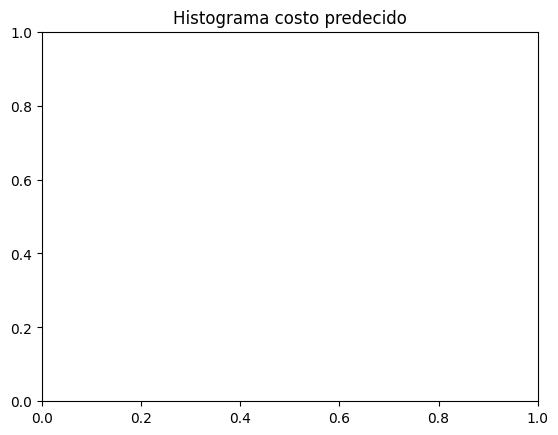

In [8]:
# Histogram of columns of v_cost_hist

plt.title("Histograma costo predecido")
plt.hist(v_cost_hist[:,0], bins=20, alpha=0.5, label='pred/opt')
plt.show()

plt.title("Histograma costo Optimo")
plt.hist(v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo voltage setpoint 1")
plt.hist(v_cost_hist[:,2], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo setpoint1 / costo optimo")
plt.hist(v_cost_hist[:,2] / v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo predecido / costo optimo")
plt.hist(v_cost_hist[:,0] / v_cost_hist[:,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

In [9]:
v_cost_hist_FCNN = v_cost_hist.copy()
unf_hist_FCNN = unf_hist[:,0].copy()

NameError: name 'v_cost_hist' is not defined

In [10]:
v_cost_hist_GNN = v_cost_hist.copy()
unf_hist_GNN = unf_hist[:,0].copy()

NameError: name 'v_cost_hist' is not defined

NameError: name 'v_cost_hist_FCNN' is not defined

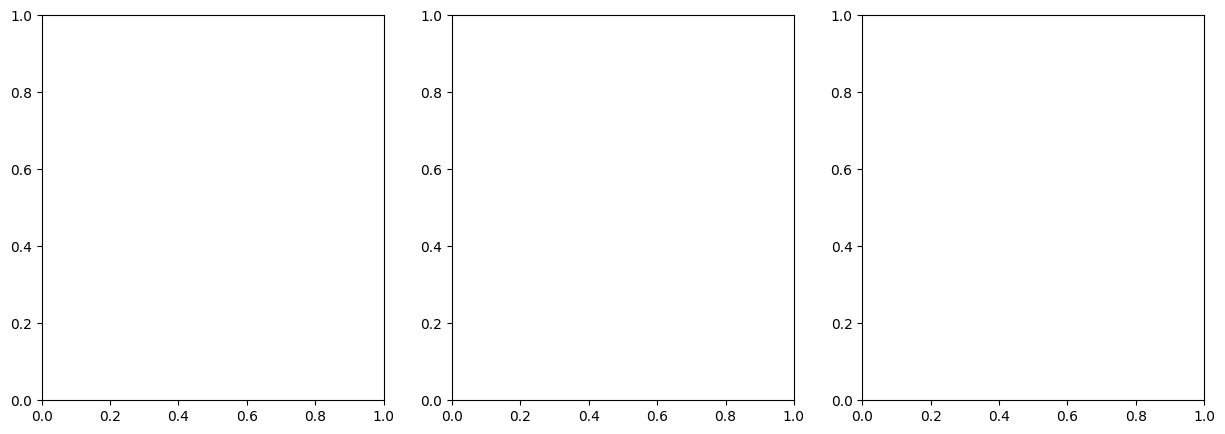

In [11]:
# 3 subplots with histograms
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].hist(v_cost_hist_FCNN[unf_hist_FCNN == 0,0] / v_cost_hist_FCNN[unf_hist_FCNN == 0,1], bins=30, range=(0.8, 1.2),alpha=0.8, weights=np.ones_like(v_cost_hist_FCNN[unf_hist_FCNN == 0,0]) / len(v_cost_hist_FCNN[unf_hist_FCNN == 0,0]) * 100, label='FCNN/opt')
axs[0].set_title("Pérdidas FCNN / pérdidas del óptimo",fontsize=14)
axs[0].grid()
axs[0].set_xlabel(r'$MW/MW$',fontsize=12)
axs[0].set_ylabel("Porcentaje de datos",fontsize=12)
axs[0].set_xlim([0.8, 1.2])
axs[0].set_ylim([0, 50])
axs[1].hist(v_cost_hist_GNN[unf_hist_GNN == 0,0] / v_cost_hist_GNN[unf_hist_GNN == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, weights=np.ones_like(v_cost_hist_GNN[unf_hist_GNN == 0,0]) / len(v_cost_hist_GNN[unf_hist_GNN == 0,0]) * 100, label='GNN/opt')
axs[1].set_title("Pérdidas GNN / pérdidas del óptimo",fontsize=14)
axs[1].grid()
axs[1].set_xlabel(r'$MW/MW$',fontsize=12)
axs[1].set_ylabel("Porcentaje de datos",fontsize=12)
axs[1].set_xlim([0.8, 1.2])
axs[1].set_ylim([0, 50])
axs[2].hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, weights=np.ones_like(v_cost_hist[unf_hist[:,2] == 0,2]) / len(v_cost_hist[unf_hist[:,2] == 0,2]) * 100, label='v1/opt')
axs[2].set_title("Pérdidas modelo básico / pérdidas del óptimo",fontsize=14)
axs[2].grid()
axs[2].set_xlabel(r'$MW/MW$',fontsize=12)
axs[2].set_ylabel("Porcentaje de datos",fontsize=12)
axs[2].set_xlim([0.8, 1.2])
axs[2].set_ylim([0, 50])

plt.tight_layout()
plt.show()

fig.savefig(f"./figs/histograma_comparacion_costos_unsup_{red}.pdf")

In [12]:
# FEASIBILITY

print(f"El porcentaje de unfeasibles en el predecido es {np.mean(unf_hist[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist[:,1], axis=0)}")
print(f"El porcentaje de unfeasibles en el setpoint 1 es {np.mean(unf_hist[:,2], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,0] == 0,0] / v_cost_hist[unf_hist[:,0] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()


plt.title("Histograma costo setpoints 1 / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

plt.title("Histograma costo predecido / costo setpoints 1 restringido a feasibles")
plt.hist(v_cost_hist[(unf_hist[:,2] == 0) * (unf_hist[:,0] == 0),0] / v_cost_hist[(unf_hist[:,2] == 0) * (unf_hist[:,0] == 0),2], bins=20, alpha=0.5, label='pred/v1')
plt.show()

NameError: name 'np' is not defined

In [13]:
FCNN = gap_percentages_hist_pred.copy()

NameError: name 'gap_percentages_hist_pred' is not defined

In [38]:
GNN = gap_percentages_hist_pred.copy()

In [14]:
import matplotlib.pyplot as plt
# # Plot the normalized histogram for pred
# plt.title("Histograma de gaps en porcentaje para pred")
# plt.hist(gap_percentages_hist_pred, bins=10, alpha=0.5, density=True)  # Normalize the histogram
# plt.show()

# # Plot the normalized histogram for opt
# plt.title("Histograma de gaps en porcentaje para opt")
# plt.hist(gap_percentages_hist_opt, bins=10, alpha=0.5, density=True)  # Normalize the histogram
# plt.show()

bins = np.linspace(0, 40, 40)  # Creates 10 bins from 0 to 10

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Define consistent limits for the x and y axes
# x_limits = (0, 6.5)
# y_limits = (0, 36) 
x_limits = (0, 25)
y_limits = (0, 100)

# Plot the normalized histogram for pred FCNN
axs[0].set_title("FCNN", fontsize=16, fontweight='bold')
axs[0].hist(FCNN, bins=bins, alpha=0.8, weights=np.ones_like(FCNN) / len(FCNN) * 100)  
axs[0].set_xlabel("Porcentaje de violación", fontsize=14)
axs[0].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].grid()

# Plot the normalized histogram for pred GNN
axs[1].set_title("GNN", fontsize=16, fontweight='bold')
axs[1].hist(GNN, bins=bins, alpha=0.8, weights=np.ones_like(GNN) / len(GNN) * 100) 
axs[1].set_xlabel("Porcentaje de violación", fontsize=14)
axs[1].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
axs[1].grid()

# Plot the normalized histogram for opt
axs[2].set_title("Óptimo", fontsize=16, fontweight='bold')
axs[2].hist(gap_percentages_hist_opt, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_opt) / len(gap_percentages_hist_opt) * 100)  
axs[2].set_xlabel("Porcentaje de violación", fontsize=14)
axs[2].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
axs[2].grid()

# Plot the normalized histogram for v1
axs[3].set_title("Modelo básico", fontsize=16, fontweight='bold')
axs[3].hist(gap_percentages_hist_v1, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_v1) / len(gap_percentages_hist_v1) * 100)  
axs[3].set_xlabel("Porcentaje de violación", fontsize=14)
axs[3].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[3].set_xlim(x_limits)
axs[3].set_ylim(y_limits)
axs[3].grid()

plt.tight_layout()
plt.show()
fig.savefig(f"./figs/gaps_unsup_{red}.pdf")

NameError: name 'np' is not defined

In [40]:
Ybus = np.asarray(net._ppc["internal"]["Ybus"].todense())
i = 10

p_load = x_tot[:,:,0]
p_load_i = p_load[i]
q_load = x_tot[:,:,1]
q_load_i = q_load[i]
p_gen = x_tot[:,:,2]
p_gen_i = p_gen[i]
p_sgen = x_tot[:,:,3]
p_sgen_i = p_gen[i]

p_ext_grid = y_pred[:,:,0]
p_ext_grid_i = p_ext_grid[i]
q_gen = y_pred[:,:,1]
q_gen_i = q_gen[i]
q_shunt = y_pred[:,:,2]
q_shunt_i = q_gen[i]
V_mag = y_pred[:,:,3]
V_mag_i = V_mag[i]
delta = y_pred[:,:,4]
delta_i = delta[i]



In [1]:
p = p_gen_i + p_ext_grid_i + p_sgen_i - p_load_i  
q = q_gen_i + q_shunt_i - q_load_i 
V = V_mag_i * (np.cos(delta_i) + np.sin(delta_i)*1j)
S = p + 1j * q
ec = np.dot(np.diag(V), np.conj(np.dot(Ybus, V)))

print(S)
print(ec)


NameError: name 'p_gen_i' is not defined

In [88]:
V

array([0.9691055 -5.99310175e-02j, 0.9927635 -9.76793654e-03j,
       0.9986692 -2.82686530e-03j, 1.0001868 +4.59995383e-04j,
       0.9982205 -4.28594742e-03j, 0.97488177-4.54969816e-02j,
       0.9808992 -3.15576978e-02j, 0.98088855-3.62185240e-02j,
       0.97619486-4.17065956e-02j, 0.9735321 -4.99544516e-02j,
       1.        +0.00000000e+00j, 0.9955222 -3.93399457e-03j,
       0.9818745 -5.07473946e-02j, 0.9969781 -4.82328841e-03j,
       0.98220897-1.48263946e-02j, 0.9771752 -1.77743565e-02j,
       0.99021935-1.05331689e-02j, 0.9913992 -1.68150607e-02j,
       0.9973026 -6.91057928e-03j, 0.99929464+7.17848598e-04j,
       0.99596936-1.45164551e-02j, 0.99685   -1.15157431e-02j,
       0.99770796-2.23690774e-02j, 1.0002375 -1.55926505e-02j,
       0.97097164-5.46281300e-02j, 0.96776134-5.76119684e-02j,
       0.9643627 -6.36641756e-02j, 0.97070366-6.06574863e-02j,
       0.97253394-5.27423695e-02j, 0.97253394-5.27423695e-02j,
       0.97081   -5.77590801e-02j, 0.97193086-5.4698020

In [77]:
y_pred[0][bus_pos(idx_gens)][:,1]

array([ 0.3262012 , -0.07920885,  0.09741989,  0.01010104,  0.01141548,
       -0.04188447,  0.04212729,  0.01109315, -0.00560234, -0.28193286,
        0.01239043,  0.14206634], dtype=float32)

In [ ]:
S_i = p_gen_i + p_ext_grid_i - p_load_i + 1j*(q_gen_i - q_load_i)
V_i  = V_mag_i * np.exp(1j * delta_i)


result = np.dot(np.diag(V_i), np.conj(np.dot(Ybus, V_i)))
print(S_i)
print(result)
print(np.abs(result-S_i))